# Image deconvolution using variational methods

This numerical tour explores the use of L2, 
Sobolev and TV regularization to perform image deconvolution.

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


In [1]:
from __future__ import division

import numpy as np
import math
from scipy.signal import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')


%pylab inline  
# or %pylab notebook
%matplotlib inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


This tour is concerned with the deconvolution problem. The measurement
are assumed to be blurry and noisy. In the continuous domain, the model is:
$$
y = h \ast f_0 + n
$$
where  $h$ is the filter (low pass) and $n$ some noise (here assumed
to be white Gaussian). Note that convolution operators are diagonalized by the Fourier transform so that:
$$
Y(\nu) = H(\nu) \cdot F(\nu)
$$

After acquisition, involving sampling and therefore discretization, the model takes the form
 
 $$
 y= H f_0 + n 
 $$
 
where $H$ is the matrix associated to the linear (discrete) convolution operator. Taking the discrete Fourier transform (DFT) of this equation yields:
$$
(\;Y(\nu_k)\;)_{0\leq k\leq N-1} = \text{diag}(\; H(\nu_k), 0\leq k \leq N-1\;) \cdot (\;F(\nu_k)\;)_{0\leq k\leq N-1}
$$

As a result, matrix products with $H$ are much simpler in the Fourier basis since 

$$
{\cal F}H{\cal F}^{-1}= \text{diag}(\; H(\nu_k), 0\leq k \leq N-1\;)
$$ 

is diagonal. Here ${\cal F}$ is the matrix of the discrete Fourier transform.

We consider variational deconvolution methods, that finds a regularizer
through a convex optimization of a composite cost function:
 $$
 f^\star \in \text{argmin}_f \frac{1}{2}\|y-H f\|_2^2 + \lambda g(f)
 $$
where $g(f)$ is a prior energy. In this tour we consider several priors including a simple L2 prior (the image is assumed to have a bounded energy), a Sobolev prior
(the image is assumed uniformly smooth) and an approximate total variation (the
image is made of close to constant regions with edges of bounded perimeter).

Note that the parameter $\lambda$ should be carefully chosen to fit the
noise level.

## Image blurring

Deconvolution corresponds to removing a blur from an image.
We use here a Gaussian blur.


First we load the image to be blurred and later restored.

In [2]:
N = 256
name = 'hibiscus.bmp'
f0 = load_image(name, N);

Initial image $f_0$.

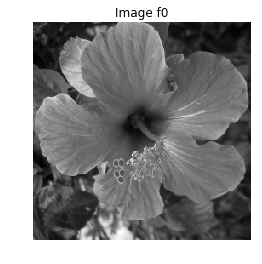

In [3]:
imageplot(f0, 'Image f0') #, [1, 2, 1])

We build a convolution kernel.

Width `w` of the kernel, in pixels.

In [4]:
w = 3

Define the convolution kernel $h$. 

Since we are going to use Fourier to compute the convolution,
we set the center of the kernel in the (0,0) pixel location within a grid ranging from -N/2 to N/2-1 in both directions. Then we need to bring this representation back in a square ranging from 0 to N-1 in both directions. This is made possible by using:

In [5]:
x = concatenate( (arange(0,N/2), arange(-N/2,0)) ); # similar to fftshift(arange(-n/2,n/2))
[Y, X] = meshgrid(x, x)
h = exp((-X**2-Y**2)/(2*w**2) )
h = h/sum(h.flatten())
 

Display the kernel and its transform.

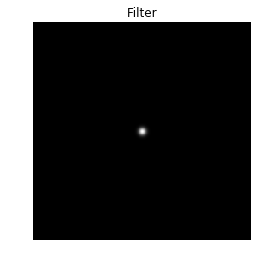

In [6]:
imageplot(ifftshift(h), 'Filter') 

Useful for later : the Fourier transform (should be real because of symmetry). We use `fftshift` to center the filter for display.

In [7]:
hF = abs(fft2(h))

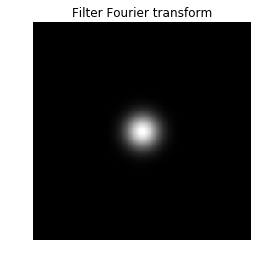

In [8]:
imageplot(fftshift(hF), 'Filter Fourier transform') #, [1, 2, 2])

We use this short hand for the filtering.
Note that this is a symmetric operator.

In [9]:
Phi = lambda f,h: real(ifft2(fft2(f)*fft2(h)))

Apply the filter.

In [10]:
y0 = Phi(f0, h)

Display the filtered observation.

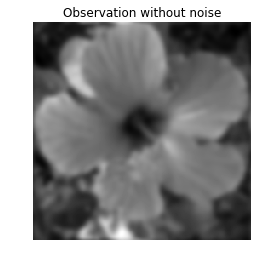

In [11]:
imageplot(y0, 'Observation without noise') #, [1, 2, 2])

Variance $\sigma^2$ of the noise $n$.

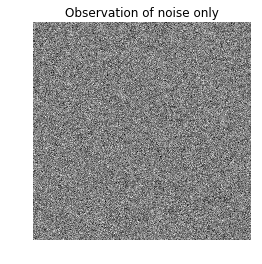

In [12]:
sigma = .05

noise_1 = randn(N,N)

imageplot(sigma*noise_1, 'Observation of noise only')

Add some noise to obtain the measurements $y = H f_0 + n$.

In [13]:
y = y0 + randn(N,N)*sigma

Display.

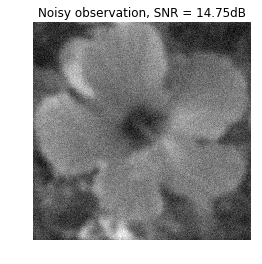

In [14]:
imageplot(y, 'Noisy observation, SNR = ' + str(round(snr(f0, y),2)) + 'dB')

## Deconvolution with L2 regularization (ridge regression)

Deconvolution could be naively obtained by dividing the Fourier transform $\hat y(\omega)$ of $y$
by $\hat h(\omega)$.
 $$f^\star(\omega) = \frac{\hat y(\omega)}{\hat h(\omega)} = \hat f_0(\omega) + \frac{\hat n(\omega)}{\hat h(\omega)}$$

Let's see if it works in the absence of noise, that is when $y_0 = H f_0$ (no noise term):

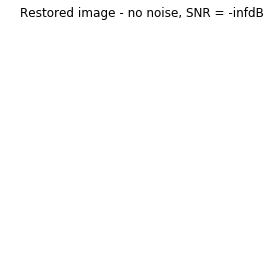

In [15]:
f_no_noise = real(ifft2(fft2(y0)/fft2(h)))

imageplot(f_no_noise, 'Restored image - no noise, SNR = ' + str(round(snr(f0, f_no_noise),2)) + 'dB')

It does not work ! You get a "not a number" message ! Unfortunately we see an explosion of the estimate `f_no_noise` where $\hat h(\omega)$ is too small: the SNR is "not a number" which warns us of the divergence.


It is simple to check that this divergence is due to a "divide-by-zero" error by simply adding a very small number to the denominator:

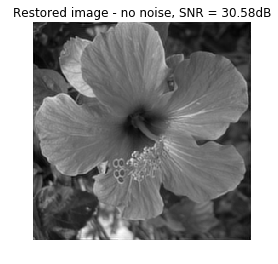

In [16]:
epsilon=1e-12

f_no_noise_eps = real(ifft2(fft2(y0)/(epsilon + fft2(h))))

imageplot(f_no_noise_eps, 'Restored image - no noise, SNR = ' + str(round(snr(f0, f_no_noise_eps),2)) + 'dB')

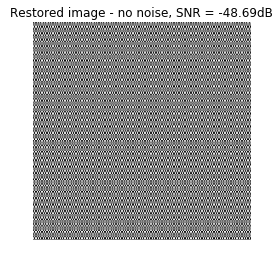

In [42]:
epsilon=1e-17

f_no_noise_eps = real(ifft2(fft2(y0)/(epsilon + fft2(h))))

imageplot(f_no_noise_eps, 'Restored image - no noise, SNR = ' + str(round(snr(f0, f_no_noise_eps),2)) + 'dB')

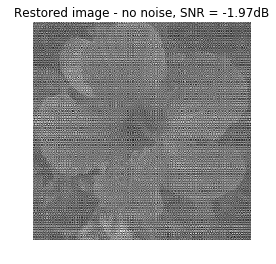

In [46]:
epsilon=1e-16

f_no_noise_eps = real(ifft2(fft2(y0)/(epsilon + fft2(h))))

imageplot(f_no_noise_eps, 'Restored image - no noise, SNR = ' + str(round(snr(f0, f_no_noise_eps),2)) + 'dB')

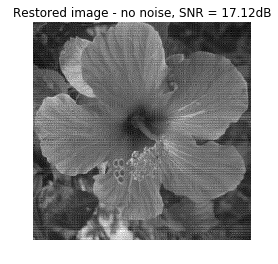

In [47]:
epsilon=1e-15

f_no_noise_eps = real(ifft2(fft2(y0)/(epsilon + fft2(h))))

imageplot(f_no_noise_eps, 'Restored image - no noise, SNR = ' + str(round(snr(f0, f_no_noise_eps),2)) + 'dB')

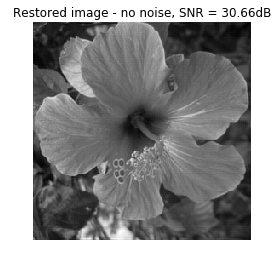

In [48]:
epsilon=1e-14

f_no_noise_eps = real(ifft2(fft2(y0)/(epsilon + fft2(h))))

imageplot(f_no_noise_eps, 'Restored image - no noise, SNR = ' + str(round(snr(f0, f_no_noise_eps),2)) + 'dB')

#### Game to play 
You can play with `epsilon` above and try values between 1e-17 and 1e-6 for instance. Observe what happens when `epsilon` gets either too small or too large.

To avoid this explosion and the sensitivity to noise, we consider a simple regularization that is usually referred to as _ridge regression_:
 $$f^{\star} = \text{argmin}_f \: \|y-\Phi f\|^2 + \lambda \|f\|^2$$



Since the filtering is diagonalized in the Fourier domain, the solution is simply
computed in the Fourier domain as:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda }$$

Let's see what happens then using a very small value of $\lambda$ such as $10^-15$ for instance.

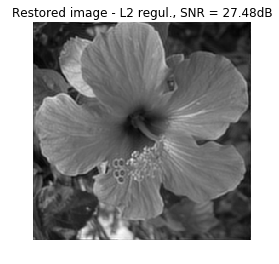

In [17]:
Lambda = 1e-15   # regularization parameter lambda

hF = fft2(h)
y0F = fft2(y0)

# Perform the inversion
f0L2 = real( ifft2(y0F*hF / (Lambda + abs(hF)**2)) )

# Show the result
imageplot(f0L2, 'Restored image - L2 regul., SNR = ' + str(round(snr(f0, f0L2),2)) + 'dB')

Now you can play to select a "best" value for the regularization parameter.

**Exercise 1:** Consider the observation `y` in the presence of noise, with a noise level of sigma=0.02 for instance. Find the optimal solution fL2 by testing several value of $\lambda$.

In [18]:
sigma = 0.02
y = y0 + randn(N,N)*sigma

yF = fft2(y)

#%run -i nt_solutions/inverse_2_deconvolution_variational/exo1

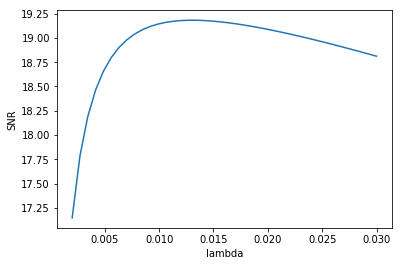

In [19]:
lambda_list = linspace(2*1e-3, .03, 40)
err = zeros( (len(lambda_list), 1) )
for i in arange(0,len(lambda_list)):
    Lambda = lambda_list[i]
    fL2 = real( ifft2( yF * hF / ( abs(hF)**2 + Lambda) ) )
    err[i] = snr(f0,fL2)
clf;
plot(lambda_list, err)
axis('tight')
xlabel('lambda')
ylabel('SNR')

i = argmax(err);
Lambda = lambda_list[i];

fL2 = real( ifft2( yF * hF / ( abs(hF)**2 + Lambda) ) )

Display optimal result that is stored in fL2:

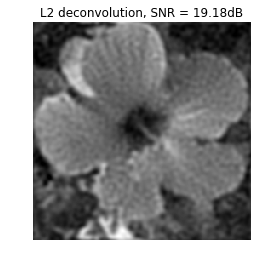

In [20]:
imageplot(clamp(fL2), 'L2 deconvolution, SNR = ' + str(round(snr(f0, fL2), 2)) + 'dB' )

## Deconvolution by Sobolev regularization.

L2 regularization did not perform a good (if any) denoising. To remove some noise, we
have to regularize the variations of the proposed solution. This can be done by penalizing high frequencies using Sobolev regularization (quadratic growth). Here we use the fact that the Fourier transform of a derivative is just $j\omega \hat f(\omega)$ so that (Plancherel):

$$
\int_{R^2} |\nabla f(x)|^2 dx = \int_{R^2} \|\omega^2\|\; |\hat{f}(\omega)|^2 d\omega
$$

The Sobolev prior reads in the discrete Frourier domain (note the conversion from spatial domain to
Fourier domain)

$$
J(f) = \sum_x \|\nabla f(x)\|^2 = \sum_{\omega} S(\omega) \|\hat f(\omega)\|^2 $
$$
where $S(\omega)=\|\omega\|^2$. 




Since this prior can be written over the Fourier domain, one can compute
the solution to the deblurring with Sobolev prior simply with the Fourier
coefficients:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda S(\omega) }$$




Compute the Sobolev prior penalty `S` (rescaled to [0,1]).

In [21]:
omega = ifftshift( arange(-N/2,N/2)*2/N )   # 1D frequencies

[omegaY, omegaX] = meshgrid(omega, omega)  # 2D frequencies

S = omegaX**2 + omegaY**2

Regularization parameter:

In [22]:
Lambda = 0.1

Perform the inversion.

In [23]:
fSob = real(ifft2(yF * hF / (abs(hF)**2 + Lambda*S)))

Display the result.

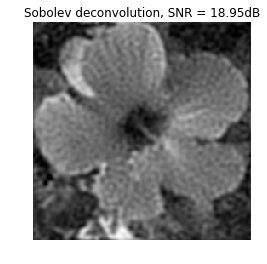

In [24]:
imageplot(clamp(fSob), 'Sobolev deconvolution, SNR = ' + str( round(snr(f0, fSob), 2) ) + 'dB' )

**Exercise 2:** Find the optimal solution fSob by testing several value of
$\lambda$.

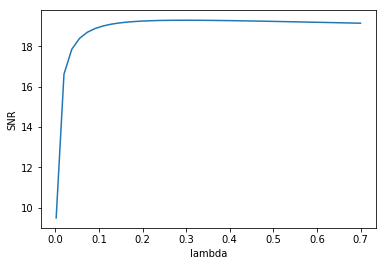

In [25]:
#%run -i nt_solutions/inverse_2_deconvolution_variational/exo2
lambda_list = linspace(2*1e-3, .7, 40)
err = zeros( (len(lambda_list), 1) )
for i in arange(0,len(lambda_list)):
    Lambda = lambda_list[i]
    fSob = real( ifft2( yF * hF / ( abs(hF)**2 + Lambda*S) ) )
    err[i] = snr(f0,fSob)
clf;
plot(lambda_list, err)
axis('tight')
xlabel('lambda')
ylabel('SNR')

i = argmax(err);
Lambda = lambda_list[i];

fSob = real( ifft2( yF * hF / ( abs(hF)**2 + Lambda*S) ) )

Display optimal result.

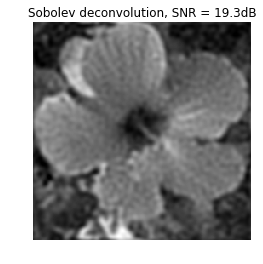

In [26]:
imageplot(clamp(fSob), 'Sobolev deconvolution, SNR = ' + str( round(snr(f0, fSob), 2) ) + 'dB' )

## Deconvolution by Total Variation regularization

Sobolev regularization performs a denoising but also tends to blur the
edges, thus producing a poor results on cartoon images.


The TV prior is able to better reconstruct sharp edges. It reads:
 $$g(f) = \sum_x \| \nabla f(x)\|$$



In principle, it simply corresponds to measuring the L1 norm instead of the L2 norm, thus dropping the square in the functional with respect to the Sobolev energy.

Unfortunately, it is not so simple in practice: the TV functional $g(f)$ is not a smooth function of the image $f$ so that there is no simple Fourier interpretation available. It thus requires the use of advanced convex optimization method to be minimized for regularization.


An alternative is to replace the absolute value by a smooth absolute value.
The smoothed TV norm reads:
 $$ g(f) = \sum_x \sqrt{\|\nabla f(x)\|^2+\varepsilon^2} $$
for some small $\varepsilon$.


Regularization parameter for the TV norm:

In [27]:
epsilon = 0.4*1e-2

When $\varepsilon$ gets close to zero, the smoothed energy becomes closer to
the original total variation, but the optimization becomes more
difficult. When `epsilon` becomes large, the smoothed energy becomes
closer to the Sobolev energy, thus blurring the edges.


Unfortunately, this prior is non-quadratic, and cannot be expressed over
the Fourier domain. 

One possibility is then to use an iterative scheme such as a
gradient descent to approximate the solution.


An iteration of the gradient descent (Landweber) reads:
 $$f^{(k+1)} = f^{(k)} - \tau \left( h \ast (h \ast f^{(k)} - y) +  \lambda \:  \text{Grad} \: g(f^{(k)})  \right)$$


Regularization parameter.

In [28]:
Lambda = 0.06

To ensure convergence of the algorithm, the value of the step size $\tau$ should be smaller than twice the Lipschitz constant of the gradient of the functional to be minimized, here:
$$
\tau< \frac{2}{1 + \lambda 8/\varepsilon }.
$$

For instance, choose:

In [29]:
tau = 1.9 / (1 + Lambda * 8 / epsilon)

Initialization.

In [30]:
fTV = y

Number of iteration (quite a large number is required).

In [31]:
niter = 150

We first check that the discretized grad and -div are adjoint one of each other.

In [32]:
a = randn(N,N)
b = randn(N,N,2)
dotp = lambda x,y: sum(x.flatten()*y.flatten())
print("Should be 0: " + str(dotp(grad(a),b) + dotp(a,div(b))) )

Should be 0: 3.410605131648481e-13


The gradient of the smoothed TV energy is:
 $$\text{Grad} \: g(f) = -\text{div}\left( \frac{\nabla f}{ \sqrt{\|\nabla f\|^2+\varepsilon^2} } \right)$$



Compute the gradient of the smoothed TV functional.

In [33]:
repeat3 = lambda x,k: resize( repeat( x, k, axis=1), [N, N, k])

Gr = grad(fTV)
d = sqrt(sum(Gr**2, axis=2) + epsilon**2)

G = -div(Gr / repeat3(d,2) )

Compute the TV norm, usefull to keep track of its decay through
iterations.

In [34]:
tv = sum(d.flatten())
print('Smoothed TV norm of the image: ' + str(round(tv,2)) )

Smoothed TV norm of the image: 2484.43


Perform a step of gradient descent for the inversion.

In [35]:
e = Phi(fTV, h)-y
fTV = fTV - tau*(Phi(e, h) + Lambda*G)

**Exercise 3:** Perform the deblurring by a  gradient descent.
Keep track of the function being minimized.

Text(0,0.5,'Energy')

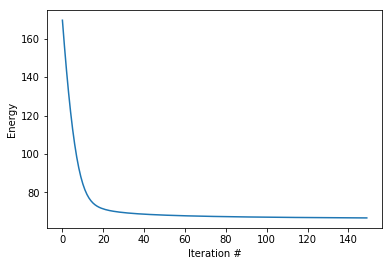

In [36]:
tau = 1.9 / ( 1 + Lambda * 8 / epsilon)
fTV = y
E = zeros((niter,1))
for i in arange(0, niter):
    # Compute the gradient of the smoothed TV functional.
    Gr = grad(fTV)
    d = sqrt(epsilon**2 + sum(Gr**2, axis=2))
    G = -div(Gr / repeat3(d,2) )
    # step
    e = Phi(fTV,h)-y
    fTV = fTV - tau*( Phi(e,h) + Lambda*G)
    # energy
    E[i] = 1/2*norm(e.flatten())**2 + Lambda*sum(d.flatten())
# display energy
clf;
plot(E)
axis('tight')
xlabel('Iteration #')
ylabel('Energy')

In [37]:
#%run -i nt_solutions/inverse_2_deconvolution_variational/exo3

Display the result.

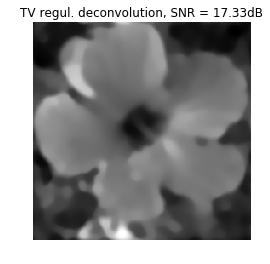

In [38]:
imageplot(clamp(fTV), 'TV regul. deconvolution, SNR = ' + str( round(snr(f0, fTV),2)  ) + 'dB' )

### Exercise 4

Explore the different values of `lambda` to find the optimal solution.
Display the SNR as a function of  `lambda`.

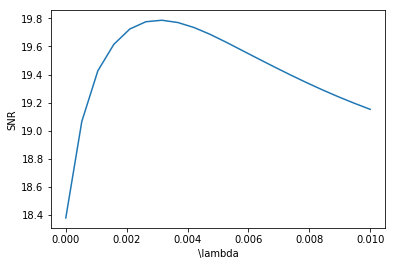

In [39]:
niter = 150
lambda_list = linspace(1e-6,.01,20)
tau = 1.9 / ( 1 + max(lambda_list) * 8 / epsilon)
fBest = y 
fTV = y
err = zeros((len(lambda_list),1))
for it in  arange(0,len(lambda_list)):
    # print('.',end="",flush=True)
    Lambda = lambda_list[it]
    for i in arange(0,niter):
        # Compute the gradient of the smoothed TV functional.
        Gr = grad(fTV)
        d = sqrt(epsilon**2 + sum(Gr**2, axis=2))
        G = -div(Gr / repeat3(d,2) )
        # step
        e = Phi(fTV,h)-y
        fTV = fTV - tau*( Phi(e,h) + Lambda*G)
    err[it] = snr(f0,fTV)
    if err[it]>snr(f0,fBest):
        fBest = fTV
clf
plot(lambda_list,err)
axis('tight')
xlabel('\lambda') 
ylabel('SNR')
fTV = fBest

In [40]:
# %run -i nt_solutions/inverse_2_deconvolution_variational/exo4

Display the result.

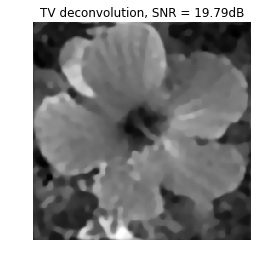

In [41]:
imageplot(clamp(fBest), 'TV deconvolution, SNR = ' + str( round(snr(f0, fBest), 2) ) + 'dB' )